In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
# Importing Libraries

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'My Drive/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))
  #gdrive/My Drive/HAR/UCI_HAR_Dataset/train/Inertial Signals/body_acc_x_train.txt

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'My Drive/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [16]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [17]:
type(X_train)

numpy.ndarray

In [18]:
X_train.shape

(7352, 128, 9)

In [19]:

X_test.shape

(2947, 128, 9)

In [20]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.3018 - acc: 0.4395 - val_loss: 1.1254 - val_acc: 0.4662
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9666 - acc: 0.5880 - val_loss: 0.9491 - val_acc: 0.5714
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.7812 - acc: 0.6408 - val_loss: 0.8286 - val_acc: 0.5850
Epoch 4/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6941 - acc: 0.6574 - val_loss: 0.7297 - val_acc: 0.6128
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6336 - acc: 0.6912 - val_loss: 0.7359 - val_acc: 0.6787
Epoch 6/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5859 - acc: 0.7134 - val_loss: 0.7015 - val_acc: 0.6939
Epoch 7/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.5692 - acc: 0.7477 - val_loss: 0.5995 - val_acc: 0.7387


In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [0]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 31s 4ms/step - loss: 1.3491 - acc: 0.4338 - val_loss: 1.1541 - val_acc: 0.5002
Epoch 2/30
7352/7352 [==============================] - 29s 4ms/step - loss: 1.0856 - acc: 0.5146 - val_loss: 0.9884 - val_acc: 0.5769
Epoch 3/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.8702 - acc: 0.6226 - val_loss: 0.8434 - val_acc: 0.6138
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7722 - acc: 0.6427 - val_loss: 0.8700 - val_acc: 0.6010
Epoch 5/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.7547 - acc: 0.6425 - val_loss: 0.8314 - val_acc: 0.6071
Epoch 6/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.6958 - acc: 0.6566 - val_loss: 0.7769 - val_acc: 0.6233
Epoch 7/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.6867 - acc: 0.6

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 511        0  ...                   0                 0
SITTING                  3      414  ...                   0                 2
STANDING                 0      109  ...                   0                 0
WALKING                  0        2  ...                   0                46
WALKING_DOWNSTAIRS       1        0  ...                   1               406
WALKING_UPSTAIRS         0        0  ...                   0               452

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 358us/step


In [0]:
score

[0.6230321966858583, 0.7614523243976926]

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.4186 - acc: 0.4203 - val_loss: 1.2296 - val_acc: 0.4445
Epoch 2/30
7352/7352 [==============================] - 29s 4ms/step - loss: 1.1453 - acc: 0.5086 - val_loss: 1.0472 - val_acc: 0.5585
Epoch 3/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.9431 - acc: 0.5819 - val_loss: 0.9246 - val_acc: 0.6071
Epoch 4/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.8193 - acc: 0.6337 - val_loss: 0.8360 - val_acc: 0.6135
Epoch 5/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.7837 - acc: 0.6629 - val_loss: 0.7449 - val_acc: 0.6295
Epoch 6/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.7353 - acc: 0.6755 - val_loss: 0.7000 - val_acc: 0.6800
Epoch 7/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.7223 - acc: 0.6944 - val_loss: 1.1260 - val_acc: 0.6274
Epoch 8

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                WALKING
True                       
LAYING                  537
SITTING                 491
STANDING                532
WALKING                 496
WALKING_DOWNSTAIRS      420
WALKING_UPSTAIRS        471


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 366us/step


In [0]:
score

[nan, 0.168306752629793]

In [0]:
#model.add(LSTM(100,return_sequences=True))
#model.add(LSTM(100))
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps,input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.6))
model.add(LSTM(n_hidden))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 182s 25ms/step - loss: 1.0818 - acc: 0.5211 - val_loss: 0.8798 - val_acc: 0.5860
Epoch 2/30
7352/7352 [==============================] - 180s 24ms/step - loss: 0.7561 - acc: 0.6289 - val_loss: 0.7403 - val_acc: 0.6970
Epoch 3/30
7352/7352 [==============================] - 176s 24ms/step - loss: 0.5837 - acc: 0.7569 - val_loss: 0.5792 - val_acc: 0.7384
Epoch 4/30
7352/7352 [==============================] - 176s 24ms/step - loss: 0.4630 - acc: 0.8096 - val_loss: 0.4445 - val_acc: 0.8541
Epoch 5/30
7352/7352 [==============================] - 174s 24ms/step - loss: 0.3371 - acc: 0.8810 - val_loss: 0.6808 - val_acc: 0.7682
Epoch 6/30
7352/7352 [==============================] - 174s 24ms/step - loss: 0.2463 - acc: 0.9124 - val_loss: 0.4473 - val_acc: 0.8707
Epoch 7/30
7352/7352 [==============================] - 174s 24ms/step - loss: 0.2

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):    
  ax.plot(x, vy, 'b', label="Validation Loss")    
  ax.plot(x, ty, 'r', label="Train Loss")    
  plt.legend()    
  plt.grid()    
  fig.canvas.draw()

In [0]:
scores = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 12s 4ms/step


Test score: 0.3534240820158526
Test accuracy: 0.9039701391245334


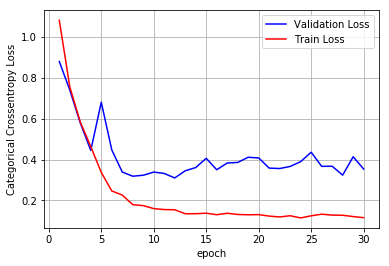

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])
 
fig,ax = plt.subplots(1,1) 
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
 
# list of epoch numbers 
x = list(range(1,epochs+1))

vy = history.history['val_loss'] 
ty = history.history['loss'] 
plt_dynamic(x, vy, ty, ax)
 

In [0]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps,input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.3))
model.add(LSTM(n_hidden))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 183s 25ms/step - loss: 1.1244 - acc: 0.5229 - val_loss: 0.9435 - val_acc: 0.5450
Epoch 2/30
7352/7352 [==============================] - 181s 25ms/step - loss: 0.7570 - acc: 0.6593 - val_loss: 0.8215 - val_acc: 0.6474
Epoch 3/30
7352/7352 [==============================] - 180s 25ms/step - loss: 0.5956 - acc: 0.7686 - val_loss: 0.6380 - val_acc: 0.7584
Epoch 4/30
7352/7352 [==============================] - 179s 24ms/step - loss: 0.4408 - acc: 0.8466 - val_loss: 0.5612 - val_acc: 0.8269
Epoch 5/30
7352/7352 [==============================] - 178s 24ms/step - loss: 0.2843 - acc: 0.9091 - val_loss: 0.4249 - val_acc: 0.8504
Epoch 6/30
7352/7352 [==============================] - 180s 24ms/step - loss: 0.2220 - acc: 0.9196 - val_loss: 0.4452 - val_acc: 0.8629
Epoch 7/30
7352/7352 [==============================] - 179s 24ms/step - loss: 0.2088 - acc: 0.9293 - val_loss: 0.4330 - val_acc: 

In [0]:
scores = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 12s 4ms/step


Test score: 0.3389693645115511
Test accuracy: 0.9097387173396675


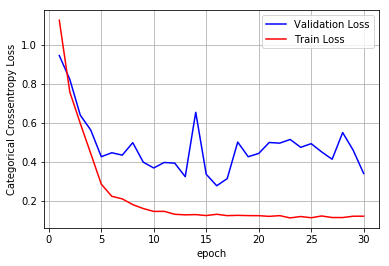

In [0]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])
 
fig,ax = plt.subplots(1,1) 
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
 
# list of epoch numbers 
x = list(range(1,epochs+1))

vy = history.history['val_loss'] 
ty = history.history['loss'] 
plt_dynamic(x, vy, ty, ax)

In [21]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(100, input_shape=(timesteps,input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(100))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 100)          44000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 125,006
Trainable params: 125,006
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [24]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 209s 28ms/step - loss: 0.9667 - acc: 0.5728 - val_loss: 0.9075 - val_acc: 0.6586
Epoch 2/30
7352/7352 [==============================] - 209s 28ms/step - loss: 0.5960 - acc: 0.7550 - val_loss: 0.6768 - val_acc: 0.7615
Epoch 3/30
7352/7352 [==============================] - 207s 28ms/step - loss: 0.3538 - acc: 0.8708 - val_loss: 0.3868 - val_acc: 0.8755
Epoch 4/30
7352/7352 [==============================] - 213s 29ms/step - loss: 0.2133 - acc: 0.9248 - val_loss: 0.4598 - val_acc: 0.8806
Epoch 5/30
7352/7352 [==============================] - 213s 29ms/step - loss: 0.1589 - acc: 0.9395 - val_loss: 0.3980 - val_acc: 0.8809
Epoch 6/30
7352/7352 [==============================] - 211s 29ms/step - loss: 0.1601 - acc: 0.9397 - val_loss: 0.3313 - val_acc: 0.9006
Epoch 7/30
7352/7352 [==============================] - 212s 29ms/step - loss: 0.1

In [25]:
scores = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 18s 6ms/step


Test score: 0.49212796406399095
Test accuracy: 0.9026128266033254


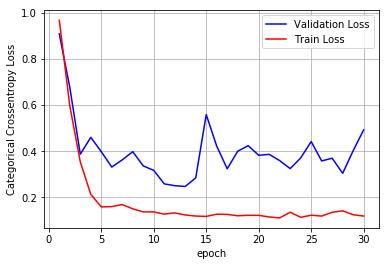

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])
 
fig,ax = plt.subplots(1,1) 
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
 
# list of epoch numbers 
x = list(range(1,epochs+1))

vy = history.history['val_loss'] 
ty = history.history['loss'] 
plt_dynamic(x, vy, ty, ax)

In [31]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(100, input_shape=(timesteps,input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 100)          44000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
Total params: 125,006
Trainable params: 125,006
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [38]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=15)

Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 210s 29ms/step - loss: 0.0552 - acc: 0.9804 - val_loss: 0.0923 - val_acc: 0.9710
Epoch 2/15
7352/7352 [==============================] - 212s 29ms/step - loss: 0.0506 - acc: 0.9816 - val_loss: 0.2160 - val_acc: 0.9455
Epoch 3/15
7352/7352 [==============================] - 213s 29ms/step - loss: 0.0487 - acc: 0.9824 - val_loss: 0.1309 - val_acc: 0.9661
Epoch 4/15
7352/7352 [==============================] - 211s 29ms/step - loss: 0.0475 - acc: 0.9821 - val_loss: 0.0972 - val_acc: 0.9699
Epoch 5/15
7352/7352 [==============================] - 213s 29ms/step - loss: 0.0509 - acc: 0.9816 - val_loss: 0.1432 - val_acc: 0.9669
Epoch 6/15
7352/7352 [==============================] - 212s 29ms/step - loss: 0.0428 - acc: 0.9838 - val_loss: 0.1031 - val_acc: 0.9706
Epoch 7/15
7352/7352 [==============================] - 212s 29ms/step - loss: 0.0459 - acc: 0.9827 - val_loss: 0.1170 - val_acc: 

In [39]:
scores = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 19s 6ms/step


Test score: 0.12714491868047254
Test accuracy: 0.9724013150891168


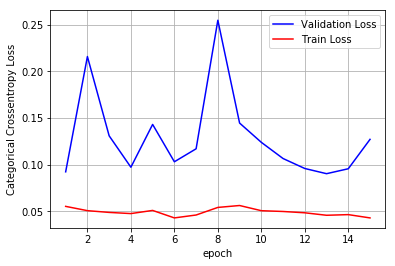

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])
 
fig,ax = plt.subplots(1,1) 
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
 
# list of epoch numbers 
x = list(range(1,15+1))

vy = history.history['val_loss'] 
ty = history.history['loss'] 
plt_dynamic(x, vy, ty, ax)

In [44]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 520        0  ...                   0                17
SITTING                  4      412  ...                   0                 2
STANDING                 0       99  ...                   0                 0
WALKING                  0        1  ...                   0                39
WALKING_DOWNSTAIRS       0        0  ...                 419                 1
WALKING_UPSTAIRS         0        3  ...                   0               463

[6 rows x 6 columns]


In [4]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ["S.No", "No.of.LSTM units","Dropouts", "No.of.Layers","Test Score","Test Accuracy"]
t.add_row([1,32,0.5,1,0.308,0.909])
t.add_row([2,32,0.6,1,0.623,0.761])
t.add_row([3,32,0.3,2,0.3389,0.909783])
t.add_row([4,100,0.5,2,0.127,0.9724])
print(t)

+------+------------------+----------+--------------+------------+---------------+
| S.No | No.of.LSTM units | Dropouts | No.of.Layers | Test Score | Test Accuracy |
+------+------------------+----------+--------------+------------+---------------+
|  1   |        32        |   0.5    |      1       |   0.308    |     0.909     |
|  2   |        32        |   0.6    |      1       |   0.623    |     0.761     |
|  3   |        32        |   0.3    |      2       |   0.3389   |    0.909783   |
|  4   |       100        |   0.5    |      2       |   0.127    |     0.9724    |
+------+------------------+----------+--------------+------------+---------------+


Conclusion:By properly tuning hyperparameters we are able to get a higher accuracy than the machine learning model which is modelled from expert designed features